# Optical Flow

 ## Shi-Tomasi corner detection + Lucas-Kanade OF
 Python + OpenCV

In [1]:
import cv2 as cv
import numpy as np

VIDEO_PATH = "data/demo/flow-01.mp4"

cap = cv.VideoCapture(VIDEO_PATH)
color = np.random.randint(0, 255, (100, 3))

# ShiTomasi corner detection
feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=7,
                      blockSize=7)

# Lucas-Kanade optical flow
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

In [2]:
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while (1):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    img = cv.add(frame, mask)

    cv.imshow('frame', img)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cv.destroyAllWindows()

## DICL-Flow
PyTorch

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

from DICL import models
from DICL.config import cfg
from DICL.utils.flow_viz import flow_to_image

# Change paths to try different images
IMG1_PATH = "data/kitti-depth/0000000000.png"
IMG2_PATH = "data/kitti-depth/0000000002.png"

# Pretrained OF network weights
WEIGHTS_PATH = "weights/ckpt_kitti.pth.tar"

In [5]:
def preprocess(input1):
    """
    Preprocessing function for input image pair.
    :param input1: tuple of two input images (B, C, H, W)
    :return: OF network input
    """
    input1 = torch.cat(input1, dim=1)
    raw_shape = input1.shape

    # Pad the input images to N*128
    height_new = int(np.ceil(raw_shape[2] / cfg.MIN_SCALE) * cfg.MIN_SCALE)
    width_new = int(np.ceil(raw_shape[3] / cfg.MIN_SCALE) * cfg.MIN_SCALE)
    padding = (0, width_new - raw_shape[3], 0, height_new - raw_shape[2])

    if cfg.PAD_BY_CONS:
        input1 = torch.nn.functional.pad(input1, padding, "constant", cfg.PAD_CONS)
    else:
        input1 = torch.nn.functional.pad(input1, padding, "replicate", 0)

    if cfg.CLAMP_INPUT:
        input1 = torch.clamp(input1, -1, 1)
        
    return input1

In [6]:
model = models.__dict__['dicl_wrapper'](None)

pretrained_dict = torch.load(WEIGHTS_PATH, map_location=torch.device('cpu'))
if 'state_dict' in pretrained_dict.keys():
    model.load_state_dict(pretrained_dict['state_dict'], strict=False)
else:
    model.load_state_dict(pretrained_dict, strict=False)

In [7]:
def load_image(path):
    image = Image.open(path)
    image = np.array(image).astype(np.float32) / 255.0
    return torch.Tensor(image).permute(2, 0, 1).unsqueeze(0)

img1 = load_image(IMG1_PATH)
img2 = load_image(IMG2_PATH)

output = model(preprocess((img1, img2)))

/Users/andreadalcin/miniconda3/envs/DNN3D/lib/python3.11/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


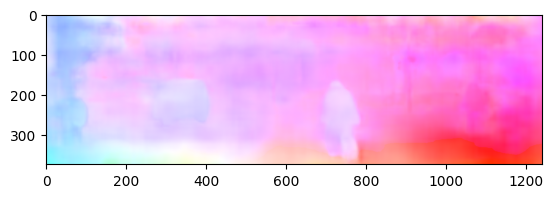

In [8]:
def output2img(output, w, h):
    flow1 = output[0]
    flow1 = F.interpolate(flow1, (h, w), mode='bilinear', align_corners=True)
    flow1[:, 0, :, :] = flow1[:, 0, :, :] * (w / flow1.shape[3])
    flow1[:, 1, :, :] = flow1[:, 1, :, :] * (h / flow1.shape[2])
    
    return flow_to_image(flow1[0].cpu().detach().numpy().transpose(1, 2, 0), valid=None)

b, _, h, w = img1.size()
plt.imshow(output2img(output, w, h))
plt.show()

### 3D from Optical Flow

In [9]:
import random

def sample_coordinates(width, height, n_samples=1000):
    coordinates = []
    for _ in range(n_samples):
        y = random.randint(0, height - 1)
        x = random.randint(0, width - 1)
        coordinates.append(np.array([y, x]))
    return coordinates

In [10]:
def apply_offset(coord, offset):
    return coord + offset.detach().numpy()

# Sample coordinates and find matches using OF
img1_coords = sample_coordinates(w, h, n_samples=1000)

f = F.interpolate(output[0], (h, w), mode='bilinear', align_corners=True).squeeze()
img2_coords = list(map(lambda c: apply_offset(c, f[:, c[0], c[1]]), img1_coords))

In [11]:
import cv2 as cv

# RANSAC to find F using OpenCV
F, mask = cv.findFundamentalMat(np.array(img1_coords),
                                np.array(img2_coords),
                                cv.FM_LMEDS,
                                ransacReprojThreshold=1.0,
                                confidence=1.0,
                                maxIters=100000)

print(f"Inlier count: {np.sum(mask)}")

K = np.array(
    [9.037596e+02, 0.000000e+00, 6.957519e+02, 
     0.000000e+00, 9.019653e+02, 2.242509e+02, 
     0.000000e+00, 0.000000e+00, 1.000000e+00]
).reshape((3, 3))

E = K.T @ F @ K
R2, _, t2 = cv.decomposeEssentialMat(E)

Inlier count: 879


In [12]:
P1 = np.dot(K, np.hstack((np.eye(3), np.zeros((3, 1)))))
P2 = np.dot(K, np.hstack((R2, t2)))

points_3d_hom = cv.triangulatePoints(P1, P2, np.array(img1_coords).T, np.array(img2_coords).T)

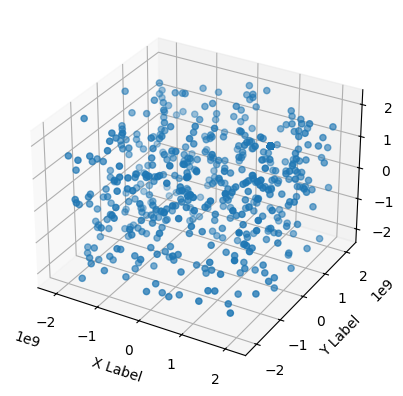

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting
ax.scatter(points_3d_hom[0, :], points_3d_hom[1, :], points_3d_hom[2, :])

# Labeling axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()